# Model creation (superresolution)

In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import tools.common_functions as cf
import tools.regression as reg

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 1
DATA_NORMAL_FORCE_FILE = f"table_calibration/2x2_hystersis_taxel2"

# Automated
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)] + ['level_sensor']


In [3]:
# Load in data file and prepare for fitting
normal_force_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG, False)
normal_force_df = cf.extract_features(normal_force_df)
normal_force_df.info()

392.5831745369845
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64507 entries, 122 to 64628
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         64507 non-null  int64  
 1   t_wall        64507 non-null  float64
 2   level_sensor  64507 non-null  float64
 3   X0            64507 non-null  float64
 4   Y0            64507 non-null  float64
 5   Z0            64507 non-null  float64
 6   X1            64507 non-null  float64
 7   Y1            64507 non-null  float64
 8   Z1            64507 non-null  float64
 9   X2            64507 non-null  float64
 10  Y2            64507 non-null  float64
 11  Z2            64507 non-null  float64
 12  X3            64507 non-null  float64
 13  Y3            64507 non-null  float64
 14  Z3            64507 non-null  float64
 15  level_robot   64507 non-null  float64
 16  F_x           64507 non-null  float64
 17  F_y           64507 non-null  float64
 18  F_z   

/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:299: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= np.mean(data[col][:window])


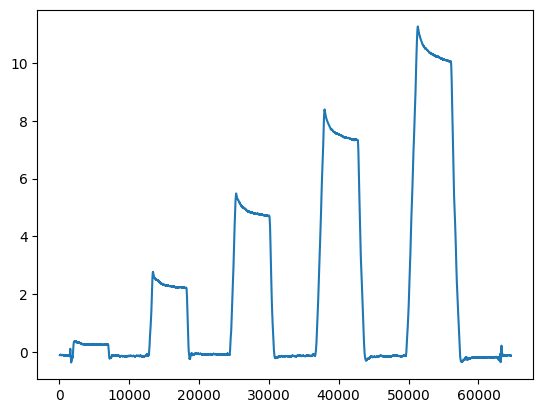

In [4]:
plt.plot(normal_force_df['F_z'])

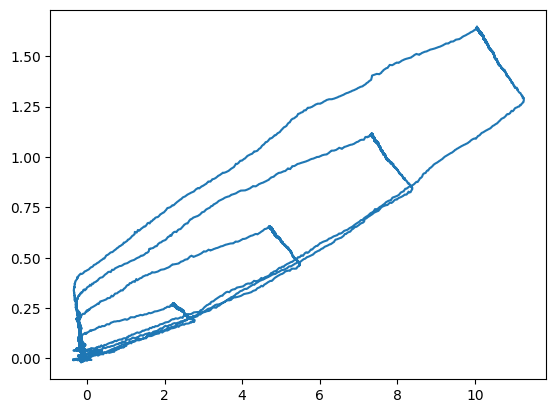

In [5]:
plt.plot(normal_force_df['F_z'], normal_force_df['Z2'])
# plt.plot([0, 1.25], [0, 11])

In [40]:
import numpy as np

class PreisachTriangle:
    def __init__(self, num_rows, num_cols, input_scaler):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.input_scaler = input_scaler
        self.prev_input = 0
        
        # Every cell in the matrix is a hysteron. The boundaries of any hysteron is its index in the matrix, scaled with max_value.
        # So triangle[2, 3] is the hysteron with upper boundary 2 * and lower boundary 3 * max_value.
        self.triangle = np.zeros((num_rows, num_cols))
        self.weights = np.ones((num_rows, num_cols))

    def apply_input(self, u):
      
      # We apply the change in input
      delta_u = u - self.prev_input
      self.prev_input = u
      
      if delta_u > 0:
        
        # Increase in input, we are going to enable all hysterons that are below the input
        self.triangle[:, :int(u / self.input_scaler * self.num_rows)] = 1
      
      elif delta_u < 0:
          
          # Decrease in input, we are going to disable all hysterons that are above the input
          self.triangle[int(u / self.input_scaler * self.num_cols):, :] = 0
          
      # Always make sure the bottom triangle is disabled
      self.triangle = np.triu(self.triangle)
    
    def apply_inputs(self, us):
      
      outputs = np.zeros(len(us))
      for i in range(len(us)):
        self.apply_input(us[i])
        outputs[i] = self.get_output()
        
      return outputs
    
    def get_output(self):
      
      # Elementwise multiplication of the triangle and the weights
      return np.sum(np.multiply(self.triangle, self.weights)) / np.sum(self.weights) / (self.num_cols * self.num_rows / 2)
      
    def plot_matrix(self):
        """
        Plot the Preisach triangle matrix.
        """
        plt.imshow(self.triangle.T, cmap='binary', origin='lower', extent=[0, 1, 0, 1])
        plt.xlabel('beta')
        plt.ylabel('alpha')
        plt.title('Preisach Triangle')
        plt.colorbar(label='Activation')
        plt.show()
        


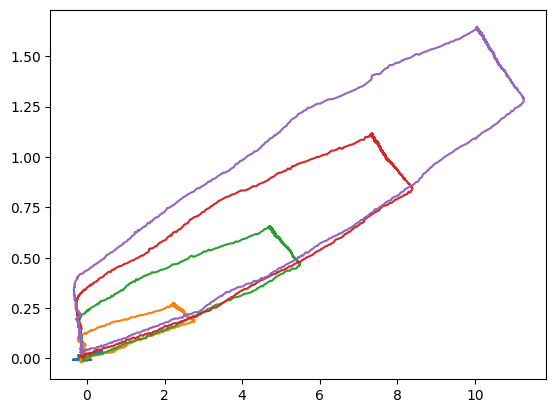

0.38209703810645734
2.7706846209778844
5.487771707946906
8.387549098574468
11.264157126078977


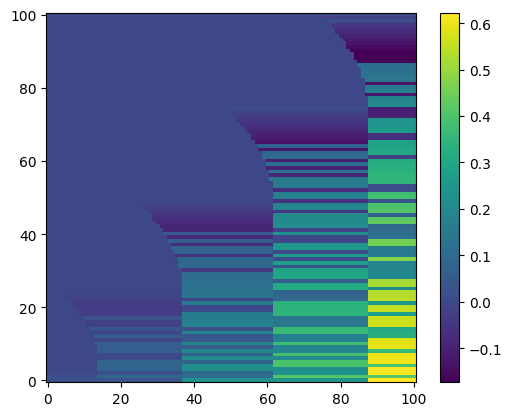

In [36]:
# Calculate the FORCs
FORC1_indices = range(0, 10000)
FORC2_indices = range(10000, 20000)
FORC3_indices = range(23000, 35000)
FORC4_indices = range(35000, 45000)
FORC5_indices = range(45000, 60000)

FORCs_indices = [FORC1_indices, FORC2_indices, FORC3_indices, FORC4_indices, FORC5_indices]

FORCs = []

# Get FORCs data as np arrays
for indices in FORCs_indices:
    FORCs.append(normal_force_df[['F_z', 'Z2']].iloc[indices].to_numpy())

# Plot
for forc in FORCs:
    plt.plot(forc[:, 0], forc[:, 1])
plt.show()

# Determine alphas per FORC
alphas = np.zeros(len(FORCs_indices))
alpha_indices = []
f_alpha = []
max_alpha = max(normal_force_df['F_z'])
for i, forc in enumerate(FORCs):
    alphas[i] = np.max(forc[:, 0])
    alpha_indices.append(np.argmax(forc[:, 0]))
    f_alpha.append(forc[alpha_indices[i], 1])
    
# Now get F_alpha_beta from FORCs
# max_alpha is the maximal value
# Bin the data into a grid
F_alhpa_betas = []
nr_of_hysterons = 100
bins = np.linspace(0, max_alpha, nr_of_hysterons)

disc_alphas = np.digitize(alphas, bins)

points = []
values = []

# for j, forc in enumerate(FORCs):
  
#     F_alpha_betas = np.zeros((nr_of_hysterons))
    
#     # We discretize the excitation to get the correct beta values on the final grid
#     u_classes = np.digitize(forc[:, 0], bins)
    
#     # Now we calculate the F_alpha_beta value for each data point in this FORC. 
#     # Note: alpha stays fixed for a given FORC
#     for i in range(nr_of_hysterons): 
#         F_alpha_betas[i] = np.mean( forc[:, 1][u_classes == i] )
    
#     # Now add the F_alpha_beta to the grid (at the correct beta val)
        
#     for i in range(nr_of_hysterons):
        
#         # Skip if nan
#         if np.isnan(F_alpha_betas[i]):
#             continue
        
#         points.append([disc_alphas[j], i])
        
#         F_grid_value = (f_alpha[j] - F_alpha_betas[i]) / 2 # See equation (3)
        
#         values.append(F_grid_value)

for j, forc in enumerate(FORCs):
    
    F_values = (f_alpha[j] - forc[:, 1]) / 2
    
    # plt.plot(F_values)
    # plt.show()
    
    print(alphas[j])
        
    for i in range(len(forc)):
        points.append([alphas[j], forc[i, 0]])
        values.append(F_values[i])

# Interpolate the data in a grid
from scipy.interpolate import griddata

points = np.array(points)
values = np.array(values)

gsize = nr_of_hysterons + 1

grid_x, grid_y = np.mgrid[0:max_alpha:gsize * 1j, 0:max_alpha:gsize * 1j]
grid = griddata(points, values, (grid_x, grid_y), method='nearest')

import matplotlib.pyplot as plt

# Calculate weights
step = bins[1]
matrix1 = grid[:-2, 2:]
matrix2 = grid[2:, 2:]
matrix3 = grid[:-2, :-2]
matrix4 = grid[2:, :-2]
weights_grid = (matrix3 + matrix2 - matrix1 - matrix4) / (4 * step ** 2)
pos = plt.imshow(grid.T, origin='lower')
plt.colorbar(pos)



[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


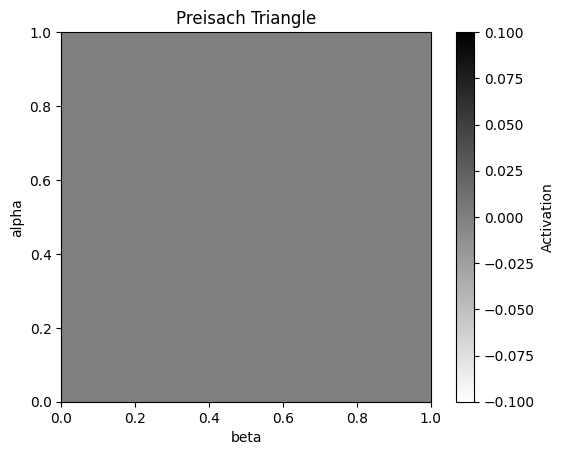

In [41]:
pm = PreisachTriangle(99, 99, max_alpha)
print(pm.weights)

weights_flipped = weights_grid.T[:, ::-1]
pm.weights = np.nan_to_num(weights_flipped)
print(pm.weights)
pm.plot_matrix()

In [42]:
outputs = pm.apply_inputs(normal_force_df['F_z'].to_numpy())

[-0.         -0.         -0.         ...  0.00017632  0.00017632
  0.00017632]


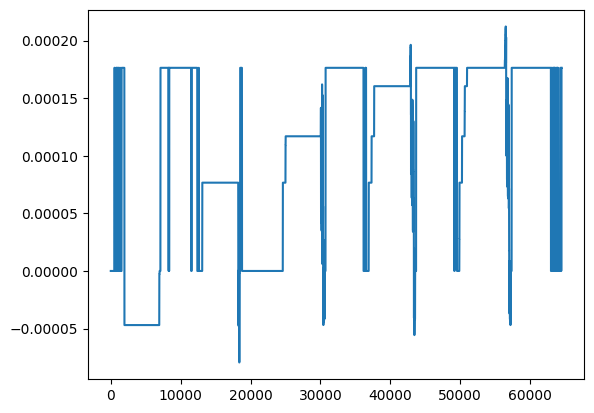

In [43]:
print(outputs)
plt.plot(outputs)

In [ ]:
num_rows = 1000
num_cols = 1000
preisach = PreisachTriangle(num_rows, num_cols, 2)

preisach.apply_input(0.5)
preisach.plot_matrix()

preisach.apply_input(1)
preisach.plot_matrix()

preisach.apply_input(0.2)
preisach.plot_matrix()

preisach.apply_input(0.8)
preisach.plot_matrix()

preisach.apply_input(0.5)
preisach.plot_matrix()

preisach.apply_input(0)
preisach.plot_matrix()

In [ ]:
u1 = np.linspace(0, 1, 100)
u2 = np.linspace(1, 0.2, 100)
u3 = np.linspace(0.2, 0.8, 100)
u4 = np.linspace(0.8, 0.5, 100)

# Get outputs
y1 = []
y2 = []
y3 = []
y4 = []
for u in u1:
    preisach.apply_input(u)
    y1.append(preisach.get_output())
for u in u2:
    preisach.apply_input(u)
    y2.append(preisach.get_output())
for u in u3:
    preisach.apply_input(u)
    y3.append(preisach.get_output())
for u in u4:
    preisach.apply_input(u)
    y4.append(preisach.get_output())

plt.plot(u1, y1, label='u1')
plt.plot(u2, y2, label='u2')
plt.plot(u3, y3, label='u3')
plt.plot(u4, y4, label='u4')
plt.legend()


In [ ]:
plt.plot(normal_force_df['Z2'])

In [ ]:
# Author: fddf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import collections
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import LinearNDInterpolator, griddata
from typing import Tuple, Callable, List
import time
import copy


def analyticalPreisachFunction1(a: float, b: float, c: float, d: float, n: float, p: float, q: float, beta: np.ndarray,
                                alpha: np.ndarray) -> np.ndarray:
    """
    Function based on Paper IEEE TRANSACTIONS ON MAGNETICS, VOL. 39, NO. 3, MAY 2003 'Analytical  Approximation  of  Preisach
    Distribution Functions' by Janos Fuezi
    """
    hm = (alpha + beta) / 2
    hc = (alpha - beta) / 2
    nom1 = c
    den1 = (1 + np.square(a) * np.square(alpha + b)) * (1 + np.square(a) * np.square(beta - b))
    nom2 = d
    den2 = np.exp(n * np.square(hm)) * np.exp(p * np.square(hc + q))
    preisach = nom1 / den1 + nom2 / den2
    # set lower right diagonal to zero
    for i in range(preisach.shape[0]):
        preisach[i, (-i - 1):] = 0
    return preisach


def analyticalPreisachFunction2(A: float, Hc: float, sigma: float, beta: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    """
    Function based on Paper 'Removing numerical instabilities in the Preisach model identification
    using genetic algorithms' by G. Consolo G. Finocchio, M. Carpentieri, B. Azzerboni.
    """
    nom1 = 1
    den1 = 1 + ((beta - Hc) * sigma / Hc) ** 2
    nom2 = 1
    den2 = 1 + ((alpha + Hc) * sigma / Hc) ** 2
    preisach = A * (nom1 / den1) * (nom2 / den2)
    # set lower right diagonal to zero
    for i in range(preisach.shape[0]):
        preisach[i, (-i - 1):] = 0
    return preisach


def initPreisachWithOnes(gridX: np.ndarray) -> np.ndarray:
    """
    Initialize the Preisach distribution function with ones over the entire Preisach-plane
    """
    preisach = np.ones_like(gridX)
    # set lower right diagonal to zero
    for i in range(preisach.shape[0]):
        preisach[i, (-i - 1):] = 0
    return preisach


def removeInBetween(arr: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function for removing in between points of an array
    """
    whipeout_indexes = np.empty(len(arr), dtype=bool)
    if len(arr) < 3:
        whipeout_indexes[:] = True
        return arr, whipeout_indexes
    else:
        range_list = list(range(1, len(arr) - 1))
        whipeout_indexes[0] = True
        whipeout_indexes[-1] = True
        for i in range_list:
            if arr[i] == arr[i - 1] == arr[i + 1]:
                whipeout_indexes[i] = False
            else:
                whipeout_indexes[i] = True
        return arr[whipeout_indexes], whipeout_indexes


def removeRedundantPoints(pointsX: np.ndarray, pointsY: np.ndarray) -> np.ndarray:
    """
    Function for removing redundant points inside vertices and horizontal lines of staircase polylines
    """
    pointsX, whipeout_indices = removeInBetween(pointsX)
    pointsY = pointsY[whipeout_indices]
    pointsY, whipeout_indices = removeInBetween(pointsY)
    pointsX = pointsX[whipeout_indices]
    return pointsX, pointsY


def preisachIntegration(w: float, Z: np.ndarray) -> np.ndarray:
    """
    Perform 2D- integration of the Preisach distribution function.
    """
    flipped = np.fliplr(np.flipud(w * Z))
    flipped_integral = np.cumsum(np.cumsum(flipped, axis=0), axis=1)
    return np.fliplr(np.flipud(flipped_integral))


class PreisachModel:
    """
    Efficient implementation of the scalar Preisach model
    """

    def __init__(self, n: int, alpha0: float) -> None:
        self.n = n
        self.alpha0 = alpha0
        self.beta0 = alpha0
        x = np.linspace(-self.beta0, self.beta0, n - 1)
        y = np.linspace(-self.alpha0, self.alpha0, n - 1)
        self.width = 2 * alpha0 / (n - 1)
        self.gridX, self.gridY = np.meshgrid(x, y)
        # flip  gridY to be compatible with definiton of preisach plane
        self.gridY = np.flipud(self.gridY)
        self.pointsX = np.array([-self.beta0], dtype=np.float64)
        self.pointsY = np.array([-self.alpha0], dtype=np.float64)
        self.interfaceX = np.array([-self.beta0, -self.beta0], dtype=np.float64)
        self.interfaceY = np.array([-self.alpha0, -self.alpha0], dtype=np.float64)
        self.historyInterfaceX: List[float] = []
        self.historyInterfaceY: List[float] = []
        self.historyU = - self.alpha0 * np.ones(1, dtype=np.float64)
        self.historyOut = np.zeros(0, dtype=np.float64)
        self.state = 'ascending'
        self.stateOld = 'ascending'
        self.stateChanged = False
        self.everett: Callable[[float, float], float]

    def __call__(self, *args, **kwargs) -> float:
        """
        Call model with input value given as argument
        """
        self.pointsX = self.interfaceX[:-1]
        self.pointsY = self.interfaceY[:-1]
        u = args[0]
        if u > self.historyU[-1]:
            self.state = 'ascending'
        elif u < self.historyU[-1]:
            self.state = 'descending'
        if self.state != self.stateOld:
            self.stateChanged = True
        else:
            self.stateChanged = False

        if self.stateChanged:
            # reached boundary
            self.pointsX = np.append(self.pointsX, self.historyU[-1])
            self.pointsY = np.append(self.pointsY, self.historyU[-1])

        if self.state == 'ascending':
            self.pointsY[self.pointsY <= u] = u
            self.pointsY[-1] = u

        elif self.state == 'descending':
            self.pointsX[self.pointsX >= u] = u
            self.pointsX[-1] = u

        self.interfaceX = np.append(self.pointsX, u)
        self.interfaceY = np.append(self.pointsY, u)

        self.interfaceX, self.interfaceY = removeRedundantPoints(self.interfaceX, self.interfaceY)

        self.stateOld = self.state
        self.historyInterfaceX.append(copy.deepcopy(self.interfaceX))
        self.historyInterfaceY.append(copy.deepcopy(self.interfaceY))
        self.historyU = np.append(self.historyU, copy.deepcopy(u))
        output = self.calculateOutput()
        self.historyOut = np.append(self.historyOut, copy.deepcopy(output))
        return output

    def setNegSatState(self) -> None:
        """
        Set the interface to negative saturation.
        """
        self.pointsX = np.array([-self.beta0], dtype=np.float64)
        self.pointsY = np.array([-self.alpha0], dtype=np.float64)
        self.interfaceX = np.array([-self.beta0, -self.beta0], dtype=np.float64)
        self.interfaceY = np.array([-self.alpha0, -self.alpha0], dtype=np.float64)
        self.resetHistory()

    def resetHistory(self) -> None:
        """
        Reset all model history parameters.
        """
        self.historyInterfaceX = []
        self.historyInterfaceY = []
        self.historyU = - self.alpha0 * np.ones(1, dtype=np.float64)
        self.historyOut = np.zeros(0, dtype=np.float64)
        self.state = 'ascending'
        self.stateOld = 'ascending'
        self.stateChanged = False

    def setDemagState(self, n: int = -1) -> None:
        """
        Function for setting the interface so that the output of the model will
        be zero initially (demagnetized state).

        Parameters
        ----------
        n : int
            Demagnetization step granularity
        """
        if n == -1:
            n = 150

        self.setNegSatState()
        excitation = np.linspace(1, 0, n)
        excitation[1::2] = - excitation[1::2]
        for i in excitation:
            self(i)

        self.resetHistory()

    def invert(self) -> 'PreisachModel':
        """
        Return inverse Preisachmodel by constructing the inverse Everett
        function from the non inverted model using first order reversal curves (FODs).

        Grid points of the inverse Everett function are defined by the response values
        of the non inverse model. Inverse Everett function values on these grid points are directly
        defined by the dominant input extrema of the non inverted model. Inverse Everett function
        on irregular grid is interpolated using irregular grid interpolation.

        For a description of Preisach model inversion also see the following paper:
        'Identification and Inversion of Magnetic Hysteresis for Sinusoidal Magnetization' by Martin Kozek and
        Bernhard Gross
        """
        invModel = PreisachModel(self.n, self.alpha0)

        # Construct set of first order reversal curves (FODs) for identification of the inverse everett map
        # number of FODs correspond to the number of Hystereon elements n in Preisach plane
        FODs = np.zeros((self.n * self.n // 2 + self.n // 2 + 1, 2), dtype=np.float64)
        Mk = np.zeros(FODs.shape[0], dtype=np.float64)
        mk = np.zeros(FODs.shape[0], dtype=np.float64)
        invEverettVals = np.zeros(FODs.shape[0], dtype=np.float64)
        cnt = 0
        print('Inverting Model...')
        for valAlpha in np.linspace(-self.alpha0, self.alpha0, self.n - 1):
            for valBeta in np.linspace(-self.beta0, valAlpha, int((valAlpha - (-self.alpha0)) // self.width)):
                FODs[cnt, 0] = valAlpha
                FODs[cnt, 1] = valBeta
                # Reset and excite non inverted model with the FODs to get the grid Points of the inverse model
                # by dominant output extrema of the non inverted model
                self.setNegSatState()
                invEverettVals[cnt] = (1 / 2) * (valAlpha - valBeta)
                Mk[cnt] = self(valAlpha)
                mk[cnt] = self(valBeta)
                cnt += 1

        points = np.zeros((len(Mk), 2), dtype=np.float64)
        points[:, 1] = np.concatenate([Mk])
        points[:, 0] = np.concatenate([mk])
        Z = np.concatenate([invEverettVals])
        # Fit interpolator function on irregular grid using linear interpolation
        invEverettInterp = LinearNDInterpolator(points, Z, fill_value=0)

        # Set interpolator as everett function of the inverse model
        invModel.setEverettFunction(invEverettInterp)

        # return inverse model
        print('Model inversion succesfull !!!')
        return invModel

    def calculateOutput(self, **kwargs) -> float:
        """
        Calculate the output of the model with the current interface.
        Negative beta0 required, because beta0 was defined to be positive,
        however in the book 'mathematical models of hysteresis' from Mayergoyz, -
        (alpha0, beta0) is defined as the left top corner of the preisach triangle.
        Therefore beta0 has to be inverted to give the correct value
        Also the parameter order was defined different E(x,y)
        """
        if kwargs.get('mode'):
            mode = kwargs['mode'].lower()
        else:
            mode = 'default'

        if mode == 'default':
            sum = 0.0
            for i in range(1, len(self.interfaceX)):
                Mk = self.interfaceY[i]
                mk = self.interfaceX[i]
                mkOld = self.interfaceX[i - 1]
                sum = sum + (self.everett(mkOld, Mk) - self.everett(mk, Mk))
            output = -self.everett(-self.beta0, self.alpha0) + 2 * sum

        else:
            # alternative output calculation
            pass

        return output

    def setEverettFunction(self, everett: Callable[[float, float], float]) -> None:
        """
        Set everett function to given interpolator function.

        Parameters
        ----------
        everett : callable python method
            Interpolator for Everett function

        """
        if not isinstance(everett, collections.abc.Callable):
            raise ValueError('Given Parameter must be a callable function')
        self.everett = everett

    def showEverettFunction(self, fig: plt.Figure) -> None:
        """
        Show the Everett function in custom figure provided as argument
        """
        ax = fig.add_subplot(111, projection='3d')
        Z = self.everett(self.gridX, self.gridY)
        ax.plot_surface(gridX, gridY, Z)
        ax.set_title('Everett Function interpolated on regular grid')
        ax.set_xlabel('beta')
        ax.set_ylabel('alpha')
        ax.set_zlabel('z')
        plt.show()

    def showInterface(self, fig: plt.Figure) -> None:
        """
        Show the current  interface in custom figure provided as argument
        """
        ax = fig.add_subplot(111)
        ax.plot(self.interfaceX, self.interfaceY, 'r', linewidth=3)
        ax.plot(np.array([-self.beta0, self.beta0, -self.beta0, -self.beta0]),
                np.array([-self.alpha0, self.alpha0, self.alpha0, -self.alpha0]), linewidth=3)
        ax.xlim(-self.beta0 * 1.1, self.beta0 * 1.1)
        ax.ylim(-self.alpha0 * 1.1, self.alpha0 * 1.1)
        ax.title('{},{}'.format(self.interfaceX.tolist(), self.interfaceY.tolist()))
        ax.xlabel('Beta coefficients')
        ax.ylabel('Alpha coefficients')
        ax.axes().set_aspect('equal')
        ax.grid()
        ax.legend(['Interface', 'Preisach Plane'])
        ax.show()

    def animateHysteresis(self) -> animation.FuncAnimation:
        # @Todo vector length of u and out must be same
        self.historyU = self.historyU[1:]

        def update_line(num, self, line1, line2, line3):
            line1.set_xdata(num)
            line1.set_ydata(self.historyU[num])
            line2.set_xdata(self.historyInterfaceX[num])
            line2.set_ydata(self.historyInterfaceY[num])
            line3.set_xdata(self.historyU[num])
            line3.set_ydata(self.historyOut[num])
            return line1, line2, line3

        frames = len(self.historyInterfaceX)

        gs = gridspec.GridSpec(1, 3, height_ratios=[1], width_ratios=[1, 1, 1])
        fig1 = plt.figure(figsize=(18, 5))
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax3 = plt.subplot(gs[0, 2])

        # create plot of input
        ax1.plot(self.historyU, linewidth=1)
        ax1.set_xlim([0, len(self.historyU)])
        ax1.set_ylim([-self.alpha0 * 1.1, self.alpha0 * 1.1])
        ax1.set_xlabel('samples')
        ax1.set_ylabel('input')

        line1, = ax1.plot([0.0], [0.0], '.', markersize=15)

        # create plot of preisach plane
        ax2.plot(np.array([-self.beta0, self.beta0, -self.beta0, -self.beta0]),
                 np.array([-self.alpha0, self.alpha0, self.alpha0, -self.alpha0]), linewidth=3)
        line2, = ax2.plot([], [], 'r', linewidth=2)
        ax2.set_xlim(-self.beta0 * 1.1, self.beta0 * 1.1)
        ax2.set_ylim(-self.alpha0 * 1.1, self.alpha0 * 1.1)
        ax2.set_xlabel('Beta coefficients')
        ax2.set_ylabel('Alpha coefficients')
        ax2.legend(['Preisach plane', 'Interface'], loc='lower right')

        # create plot of hysteresis
        ax3.plot(self.historyU, self.historyOut)
        line3, = ax3.plot([0.0], [0.0], '.', markersize=15)

        simulation = animation.FuncAnimation(fig1, update_line, frames,
                                             fargs=(self, line1, line2, line3), interval=25,
                                             blit=True, repeat=False)

        plt.show()
        return simulation


if __name__ == "__main__":

    model = PreisachModel(200, 1)
    gridX = model.gridX
    gridY = model.gridY
    width = model.width

    ######## init with ones #########
    # preisach = initPreisachWithOnes()

    # ####### analytic 1 #############
    # A = 71
    # B = -0.018
    # C = 0.013
    # D = 0.068
    # N = 15
    # P = 2500
    # Q = 0.04
    # preisach = analyticalPreisachFunction1(A, B, C, D, N, P, Q, gridX, gridY)

    ######## analytic 2 #############
    A = 1
    Hc = 0.01
    sigma = 0.03
    preisach = analyticalPreisachFunction2(A, Hc, sigma, gridX, gridY)

    # Calculate Everett function from preisach function
    everett = preisachIntegration(width, preisach)

    # Scale Everett function to a maximum value of 1
    everett = everett / np.max(everett)

    # Calculate linear Interpolator for Everett function
    points = np.zeros((everett.size, 2), dtype=np.float64)
    points[:, 0] = gridX.flatten()
    points[:, 1] = gridY.flatten()
    values = everett.flatten()
    everettInterp = LinearNDInterpolator(points, values)
    model.setEverettFunction(everettInterp)

    # show everett function of model
    fig = plt.figure()
    model.showEverettFunction(fig)

    # calculate inverse model
    invModel = model.invert()

    # show everett function of inverse model
    fig = plt.figure()
    invModel.showEverettFunction(fig)

    # Create excitation signal
    nSamps = 2500
    phi = np.linspace(0, 2 * np.pi + np.pi / 2, nSamps)

    sawtooth = np.zeros(nSamps, dtype=np.float64)
    sawtooth[phi < np.pi / 2] = 0.7 * 2 / np.pi * phi[phi < np.pi / 2]
    sawtooth[np.logical_and(phi < 3 * np.pi / 2, phi > np.pi / 2)] = -0.7 * 2 / np.pi * (
            phi[np.logical_and(phi < 3 * np.pi / 2, phi > np.pi / 2)] - np.pi)
    sawtooth[phi > 3 * np.pi / 2] = 0.7 * 2 / np.pi * (phi[phi > 3 * np.pi / 2] - 2 * np.pi)

    input = 0.15 * np.sin(30 * phi) + sawtooth
    output = np.zeros_like(input, dtype=np.float64)
    middle = np.zeros_like(input, dtype=np.float64)

    model.setDemagState(80)
    invModel.setDemagState(80)

    # Apply input to inverse model and then apply it to non inverse model
    for i in range(len(input)):
        middle[i] = model(input[i])
        output[i] = invModel(middle[i])

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(input)
    # ax.plot(middle)
    # ax.plot(output)
    # ax.legend(['input', 'middle', 'output'])
    # plt.show()

    simulation1 = model.animateHysteresis()
    simulation2 = invModel.animateHysteresis()
    # Uncomment the next line if you want to save the animation
    # simulation1.save(filename='hysterese_simulation.mp4', fps=30, dpi=300)
    # simulation2.save(filename='hysterese_invertiert_simulation.mp4', fps=30, dpi=300)

In [ ]:
# Now fit weights
from scipy.optimize import nnls, minimize

num_rows = 5
num_cols = 5
preisach = PreisachTriangle(num_rows, num_cols, 2)

def cost_function(x, pm : PreisachTriangle, u, y):
  
  # Reset pm
  pm.apply_input(0)
  pm.prev_input = 0
  
  print("Cost")
  
  # Set weights
  pm.weights = x.reshape(pm.weights.shape)
  
  # Apply inputs one by one
  outputs = pm.apply_inputs(u)
  
  # Return RMS
  return np.sqrt(np.mean((outputs - y)**2))


weights = minimize(cost_function, np.ones(num_rows * num_cols), args=(preisach, normal_force_df['Z2'].to_numpy(), normal_force_df['F_z'].to_numpy()), method='Nelder-Mead', options={'maxiter': 10, 'disp': True})

In [ ]:
import hysteresis as hys

xy = np.column_stack([normal_force_df['Z2'], normal_force_df['F_z']])

myHys = hys.Hysteresis(xy)
myHys.plot(showReversals = True)

In [ ]:
dataset = normal_force_df[['Z2', 'F_z']].copy()

# split into train and test sets
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

print(train.shape, test.shape)

plt.plot(train['Z2'], train['F_z'])
plt.plot(test['Z2'], test['F_z'])

In [ ]:
# Split the data
def create_dataset(dataset, nr_steps):
    dataX, dataY = [], []
    for i in range(dataset.shape[0] - nr_steps - 1):
        a = dataset[i:(i + nr_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + nr_steps, 1])
    return np.array(dataX), np.array(dataY)

def create_dataset_single(dataset, nr_steps):
    dataX = []
    for i in range(dataset.shape[0] - nr_steps - 1):
        a = dataset[i:(i + nr_steps)]
        dataX.append(a)
    return np.array(dataX)

n_steps = 50
features = 1

# split into samples
X_train, y_train = create_dataset(train.to_numpy(), n_steps)
X_test, y_test = create_dataset(test.to_numpy(), n_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Building an RNN

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

# Define LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True))  
model.add(LSTM(16))  
model.add(Dense(1, activation='relu'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=Adam(0.01), loss=MeanSquaredError(), metrics=['accuracy'])


# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

In [ ]:

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

print(trainPredict.shape)
print(testPredict.shape)

print(y_train.shape)
print(y_test.shape)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (n_steps*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
# plt.plot(dataset['Z2'], dataset['F_z'])
# plt.plot(dataset['Z2'],trainPredictPlot)
plt.plot(dataset['Z2'],testPredictPlot)
plt.show()

plt.plot(dataset['F_z'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:

X = np.concatenate((np.linspace(0, 0.5, 1000), np.linspace(0.5, 0, 1000)))
X = create_dataset_single(X, n_steps)
print(X.shape)
y = model.predict(X.reshape(X.shape[0], 1, X.shape[1]))
print(y.shape)
plt.plot(y)
# plt.plot(X, y)

# Validation

In [ ]:
# Validate against the subsampled version
# Load in data file and prepare for val
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
normal_force_df_val.info()

In [ ]:
combined_model = reg.CombinedModel([normal_force_models_taxels[i] for i in [3, 2, 0, 1]])

In [ ]:
# Predict F_z{i} based on measurements
X = normal_force_df_val[[f'Z{i}' for i in range(ARRAY_SIZE)]].to_numpy()
F_zi = combined_model.predict(X)
for i in range(4):
  plt.plot(normal_force_df_val[f'F_z'])
  plt.plot(F_zi[:, i])
  plt.show()

In [ ]:
# Try to add them all up
plt.plot(normal_force_df_val['F_z'])
plt.plot(np.sum(F_zi, axis=1))


In [ ]:
# Check the distribution of all touch points F_z values
F_z_pred = np.sum(F_zi, axis=1)
F_z_virt = []

print(F_zi.shape)
print(F_z_pred.shape)

for i in range(ARRAY_SIZE):
  F_z_virt.append(F_zi[:, i] / F_z_pred)
  
for v in F_z_virt:
  print(v.shape)
  plt.plot(v[3000:])
  # plt.ylim(0, 1)
  plt.show()


In [ ]:
# Create a model that predicts the virtual taxels based on multi-taxel force models
